# Baseline จาก tutorial
## https://github.com/WasinUddy/Music-Generator

## model

In [2]:
# นำเข้า library ที่จำเป็น
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

In [6]:
#โหลดโน๊ตที่เรา preprocess เอาไว้ก่อนหน้านั้น
with open('../data/notes_final.pkl', 'rb') as f:
    notes = pickle.load(f) 

In [7]:
# กำหนดให้ n เป็น จำนวนของโน๊ตทั้งหมดที่่เป็นไปได้ในชุดข้อมูล
n = len(set(notes))


In [4]:
n

1140

In [8]:
# กำหนดความยาวของ sequence ที่ต้องการใช้เพื่อทำนายตัวถัดไป
sequence_length = 100

# สร้าง dictionary สำหรับการแปลงจากโน๊ตให้เป็นตัวเลข
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# window sliding
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# ทำให้ input อยู่ในรูปแบบที่ tensorflow model สามารถอ่านได้
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# ทำให้ ตัวเลขแต่ละตัวเป็นค่าทศนิยมระหว่าง 0 กับ 1 -> ทำให้โมเดลเรียนรู้ได้
network_input = network_input / float(n)
# ทำให้ label เป็น onehot
network_output = to_categorical(network_output)

In [6]:
# ตรวจสอบขนาด input
network_input.shape

(235009, 100, 1)

In [7]:
# ตรวจสอบขนาด label
network_output.shape

(235009, 1140)

In [8]:
# n_vocab คือจำนวนโน๊ตทั้งหมดที่เป็นไปได้ -> เอามาจากความยาวของ onehot ใน label
n_vocab = network_output.shape[-1]

In [9]:
#Create Model
model = Sequential()
model.add(layers.LSTM(256, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True)) 
# ใช้ model.add() ในการเพิ่ม layer ให้กับ model             
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64))

# classifier ที่มีขนาดเท่ากับจำนวนโน๊ตที่เป็นไปได้
model.add(Dense(n_vocab))
# softmax activation
model.add(Activation('softmax'))
# compile model โดยใส่ loss function , optimizer, และ metrics
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.Accuracy()])

In [11]:
# model checkpoint -> บันทึก model ระหว่างการ train โดยดูจากพัฒนาการของโมเดล
filepath = "weight_bidirectional_layernorm/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]



In [12]:
# เริ่มการ train
history = model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)

Epoch 1/84
1837/1837 [==============================] - 44s 22ms/step - loss: 1.7763 - accuracy: 0.0000e+00
Epoch 2/84
1837/1837 [==============================] - 41s 22ms/step - loss: 1.7719 - accuracy: 0.0000e+00
Epoch 3/84
1837/1837 [==============================] - 41s 22ms/step - loss: 1.7708 - accuracy: 0.0000e+00
Epoch 4/84
1837/1837 [==============================] - 41s 22ms/step - loss: 1.7653 - accuracy: 0.0000e+00
Epoch 5/84
1837/1837 [==============================] - 41s 23ms/step - loss: 1.7614 - accuracy: 0.0000e+00
Epoch 6/84
1837/1837 [==============================] - 41s 22ms/step - loss: 1.7574 - accuracy: 0.0000e+00
Epoch 7/84
1837/1837 [==============================] - 41s 22ms/step - loss: 1.7512 - accuracy: 0.0000e+00
Epoch 8/84
1837/1837 [==============================] - 42s 23ms/step - loss: 1.7471 - accuracy: 0.0000e+00
Epoch 9/84
1837/1837 [==============================] - 42s 23ms/step - loss: 1.7445 - accuracy: 0.0000e+00
Epoch 10/84
1837/1837 [=====

<AxesSubplot:>

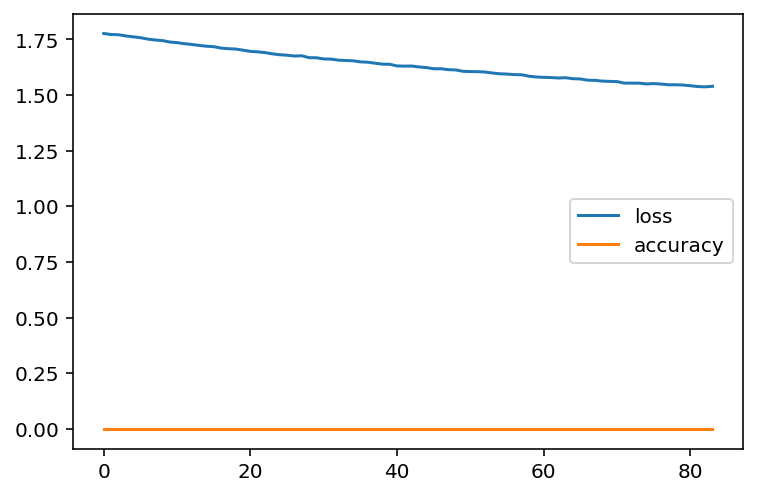

In [13]:
# ทำการ plot ค่าต่างๆในการเทรน
import pandas as pd

pd.DataFrame(history.history).plot()

In [14]:
# กรณีที่ต้องการเทรนโมเดลต่อจาก checkpoint ที่มีอยู่แล้ว

#model_ckpt = tf.keras.models.load_model("PATH/TO/MODEL/CKPT")

#history = model_ckpt.fit(network_input, network_output, epochs=1000, batch_size=128, callbacks=callbacks_list, initial_epoch=289)

In [15]:
model.save("tutorial.hdf5")

## inference

In [3]:
music_generator = tf.keras.models.load_model("tutorial.hdf5")

In [9]:
### utils function that writes .midi files

def create_midi(prediction_output, filename):
    from music21 import note, chord, instrument, stream
    offset = 0
    output_notes = []

        # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
            # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

            # increase offset each iteration so that notes do not stack
        offset += 0.25

    midi_stream = stream.Stream(output_notes)

    midi_stream.write("midi", fp=filename)
    return midi_stream

In [12]:
### ดัดแปลง generation pipeline จาก tutorial เล็กน้อย
import random
testing_model = music_generator

start = np.random.randint(0, len(network_input)-1)


pitchnames = sorted(set(item for item in notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = np.reshape(random.choices(list(range(len(int_to_note))), k=100), (100, 1))
window_size = sequence_length
prediction_output = []

# doing auto regressive generation
for note_indx in tqdm(range(200)):
    prediction_input = tf.reshape(pattern, (1, len(pattern), 1))[:, note_indx:note_indx+window_size, :]

    prediction = testing_model(prediction_input)
    # get prediction
    index = tf.argmax(prediction, axis=-1)
    
    # get note from prediction
    result = int_to_note[index.numpy()[0]]
    # add to output
    prediction_output.append(result)
    # add predicted note to the input sequence
    pattern = tf.concat((pattern, tf.expand_dims(index, axis=0)), axis=0)

    

create_midi(prediction_output, "tutorial_result_02.mid")

100%|██████████| 200/200 [00:06<00:00, 33.06it/s]


<music21.stream.Stream 0x21e93beb340>

In [21]:
index

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1112], dtype=int64)>

In [25]:
pattern

[152,
 852,
 846,
 1136,
 778,
 211,
 1067,
 227,
 454,
 986,
 991,
 573,
 388,
 954,
 678,
 1008,
 554,
 0,
 1123,
 165,
 269,
 440,
 325,
 878,
 393,
 17,
 1071,
 533,
 318,
 417,
 473,
 660,
 1120,
 203,
 914,
 855,
 650,
 503,
 1102,
 708,
 740,
 973,
 93,
 903,
 356,
 571,
 718,
 789,
 806,
 114,
 913,
 318,
 1114,
 171,
 375,
 34,
 500,
 911,
 634,
 533,
 999,
 291,
 590,
 674,
 632,
 766,
 452,
 177,
 197,
 985,
 778,
 857,
 911,
 584,
 679,
 761,
 428,
 344,
 46,
 297,
 386,
 504,
 217,
 357,
 1107,
 1087,
 1117,
 660,
 711,
 883,
 941,
 244,
 505,
 1042,
 8,
 331,
 162,
 90,
 155,
 749]

In [29]:
with open("../data/int_to_note.pkl", "wb") as f:
    pickle.dump(int_to_note, f)